In [2]:
library(XML)
library(repr)
library(scales)
library(pracma)
library(gtools)
library(foreach)
library(stringr)
library(R.matlab)
library(doParallel)
library(scatterplot3d)

library(grid)
library(extrafont)
library(latex2exp)
library(RColorBrewer)

library("graphics")
library("ggplot2")
library("scatterplot3d")

loadfonts(quiet = TRUE)
loadfonts(device = "postscript", quiet = TRUE)

names(postscriptFonts())

[1] "serif"                "sans"                 "mono"                
 [4] "AvantGarde"           "Bookman"              "Courier"             
 [7] "Helvetica"            "Helvetica-Narrow"     "NewCenturySchoolbook"
[10] "Palatino"             "Times"                "URWGothic"           
[13] "URWBookman"           "NimbusMon"            "NimbusSan"           
[16] "URWHelvetica"         "NimbusSanCond"        "CenturySch"          
[19] "URWPalladio"          "NimbusRom"            "URWTimes"            
[22] "ArialMT"              "ComputerModern"       "ComputerModernItalic"
[25] "Japan1"               "Japan1HeiMin"         "Japan1GothicBBB"     
[28] "Japan1Ryumin"         "Korea1"               "Korea1deb"           
[31] "CNS1"                 "GB1"

In [3]:
url = "http://167.99.155.161:8000/MRC/Data/swarm_simulations/"
doc = htmlParse(url)
links = xpathSApply(doc, "//a/@href")
sim_dirs = vector("list")
for (i in seq(1, length(links))){
    remote_item = unname(links[i])
    if (str_sub(remote_item,start=-1) == .Platform$file.sep){
           sim_dirs[i] = remote_item
    }
}
paste(sim_dirs)

[1] "data_icR_1_ilR_1/" "data_icR_1_ilR_2/" "data_icR_1_ilR_3/"
 [4] "data_icR_1_ilR_4/" "data_icR_1_ilR_5/" "data_icR_2_ilR_1/"
 [7] "data_icR_2_ilR_2/" "data_icR_2_ilR_3/" "data_icR_2_ilR_4/"
[10] "data_icR_2_ilR_5/" "data_icR_3_ilR_1/" "data_icR_3_ilR_2/"
[13] "data_icR_3_ilR_3/" "data_icR_3_ilR_4/" "data_icR_3_ilR_5/"
[16] "data_icR_4_ilR_1/" "data_icR_4_ilR_2/" "data_icR_4_ilR_3/"
[19] "data_icR_4_ilR_4/" "data_icR_4_ilR_5/" "data_icR_5_ilR_1/"
[22] "data_icR_5_ilR_2/" "data_icR_5_ilR_3/" "data_icR_5_ilR_4/"
[25] "data_icR_5_ilR_5/"

In [4]:
remote_mat_read <- function(r_url){
    
    mat_data = readMat(r_url)
    N = mat_data$N            # number of particle, 200
    alpha = mat_data$alpha    # fixed param, 1.5 
    beta = mat_data$beta      # fixed param, 0.5
    cA = mat_data$cA          # fixed param, 1.0
    cR = mat_data$cR
    iR = mat_data$iR
    lA = mat_data$lA          # fixed param, 1.0
    lR = mat_data$lR
    tseries = mat_data$t
    sim_data = mat_data$z
    tpoints = length(tseries) # number of timesteps, 2001
    
    if (length(sim_data) == tpoints * 4 * N){
        xpos = matrix(nrow = N, ncol = tpoints)
        ypos = matrix(nrow = N, ncol = tpoints)
        xvel = matrix(nrow = N, ncol = tpoints)
        yvel = matrix(nrow = N, ncol = tpoints)
        for (itr in seq(1, length(tseries))){
            xpos[,itr] = sim_data[itr, 1:N]
            ypos[,itr] = sim_data[itr, (N+1):(2*N)]
            xvel[,itr] = sim_data[itr, (2*N+1):(3*N)]
            yvel[,itr] = sim_data[itr, (3*N+1):(4*N)]
        }
        xpos[xpos > 11] = 11
        xpos[xpos < -11] = -11
        ypos[ypos > 11] = 11
        ypos[ypos < -11] = -11
        return(list("N" = N, "cR" = cR, "lR" = lR, "iR" = iR,
                   "xpos" = xpos, "ypos" = ypos, "xvel" = xvel, "yvel" = yvel))
    } else {
        print("ERROR: Unexpected file size.")
        return(NULL)
    }
    
}

In [5]:
obtain_sim_url <- function(icR, ilR, iR){
    
    sep = .Platform$file.sep
    sim_folder = paste('data_icR_', icR, '_ilR_', ilR, sep="")
    mat_file = paste('data_icR_', icR, '_ilR_', ilR, '_iR_', iR, '.mat', sep="")
    return(paste(url, sim_folder, sep, mat_file, sep=""))
    
}

In [6]:
plot_sim <- function(xpos, ypos, tpoint){
    
    options(repr.plot.width=5, repr.plot.height=5)
    plot(xpos[,tpoint], ypos[,tpoint], xlab="X", ylab="Y")
    
}

In [7]:
max_pos = 12
min_pos = -12
max_vel = 12 
min_vel = -12

In [14]:
mat_url = obtain_sim_url(3, 2, 5)
sim_data = remote_mat_read(mat_url)
str(sim_data)

List of 8
 $ N   : num [1, 1] 200
 $ cR  : num [1, 1] 0.9
 $ lR  : num [1, 1] 0.5
 $ iR  : num [1, 1] 5
 $ xpos: num [1:200, 1:2001] -0.0752 -0.5258 0.1975 0.6281 -0.2145 ...
 $ ypos: num [1:200, 1:2001] 0.165 0.824 0.791 0.215 0.575 ...
 $ xvel: num [1:200, 1:2001] 0.21 -0.411 -0.638 -0.215 0.417 ...
 $ yvel: num [1:200, 1:2001] 0.707 0.494 -0.752 0.895 0.68 ...


In [176]:
sim_data$xpos = (sim_data$xpos - min_pos)/(max_pos - min_pos)
sim_data$ypos = (sim_data$ypos - min_pos)/(max_pos - min_pos)
sim_data$xvel = (sim_data$xvel - min_vel)/(max_vel - min_vel)
sim_data$yvel = (sim_data$yvel - min_vel)/(max_vel - min_vel)

In [177]:
x_COM = mean(sim_data$xpos[,1:100])
y_COM = mean(sim_data$ypos[,1:100])

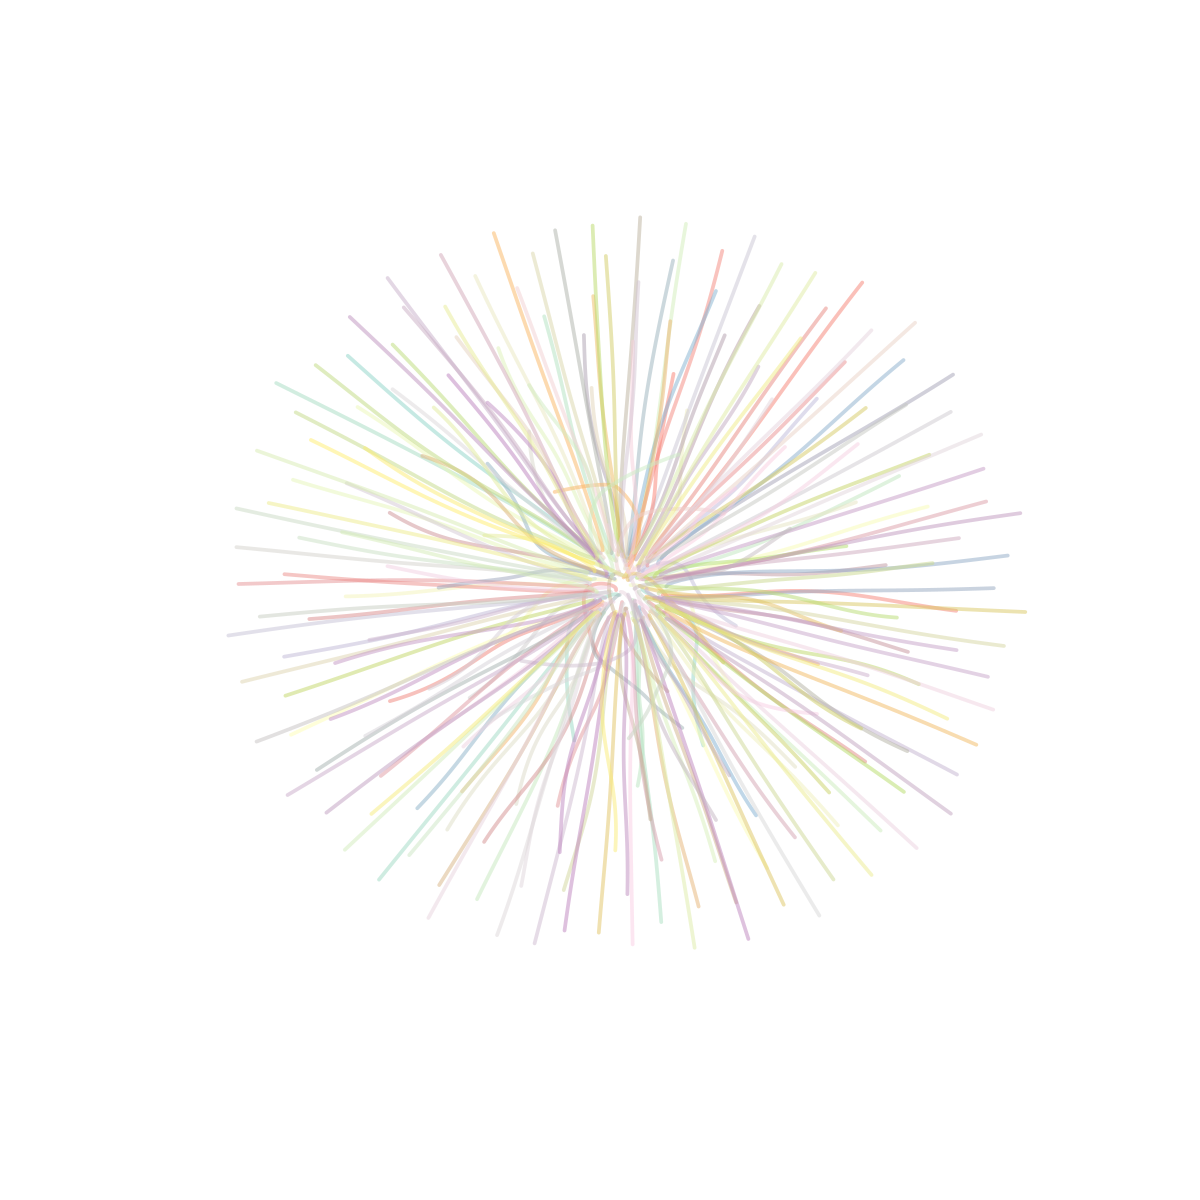

In [178]:
maxTime = 70
ax_limits = 0.5  #0.02, 0.5, 0.5
cmap = colorRampPalette(brewer.pal(12, "Set3"))(200)
options(repr.plot.width=10, repr.plot.height=10)

plot(sim_data$xpos[1,1:maxTime]-x_COM,sim_data$ypos[1,1:maxTime]-y_COM, type='l', 
     xlim=c(-ax_limits,ax_limits), ylim=c(-ax_limits,ax_limits), xlab='', ylab='', xaxt='n', yaxt='n', 
     lwd=3, col=alpha(cmap[1], seq(0.5, 1.0, length.out = maxTime)), axes=F)

for (pid in seq(2, 200)){
    lines(sim_data$xpos[pid,1:maxTime]-x_COM, sim_data$ypos[pid,1:maxTime]-y_COM, lwd=3, 
          col=alpha(cmap[pid], seq(0.5, 1.0, length.out = maxTime)))
}

In [15]:
tp = 2000
xdata = sim_data$xpos[,tp]
ydata = sim_data$ypos[,tp]
xv = sim_data$xvel[,tp]
yv = sim_data$yvel[,tp]
xdata_old = sim_data$xpos[,tp-5]
ydata_old = sim_data$ypos[,tp-5]

x_CM = mean(sim_data$xpos[,tp])
xv_CM = mean(sim_data$xvel[,tp]) 
y_CM = mean(sim_data$ypos[,tp])
yv_CM = mean(sim_data$yvel[,tp])

is_clock_wise = ((sim_data$xpos[,tp] - x_CM)*(sim_data$yvel[,tp] - yv_CM) - 
                 (sim_data$ypos[,tp] - y_CM)*(sim_data$xvel[,tp] - xv_CM)) > 0

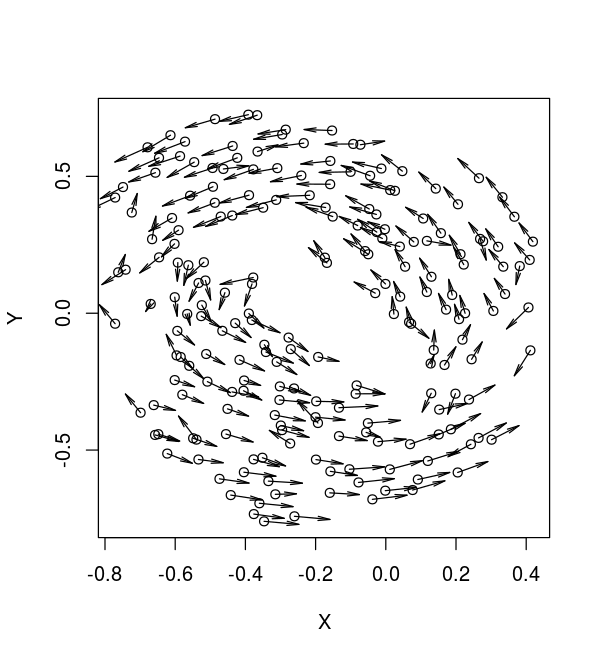

In [16]:
options(repr.plot.width=5, repr.plot.height=5.5)
plot(xdata, ydata, xlab="X", ylab="Y")
quiver(xdata, ydata, (xv-mean(xv))*0.1, (yv-mean(yv))*0.1, scale=0.5, length=0.1, angle=1)

In [17]:
ggplot_sim <- function(xpos, ypos, x_label, y_label, clab){
    gp = ggplot() + geom_point(aes(x=xpos, y=ypos, color=clab))
    gp = gp + scale_color_manual(values=c("#ee0000", "#0000ee"))
    gp = gp + xlab(TeX(x_label)) + ylab(TeX(y_label)) + theme_bw()
    gp = gp + theme(panel.grid.minor = element_blank())
    gp = gp + theme(legend.position = "none")
    return(gp)
}

In [18]:
ggplot_quiver <- function(xpos, ypos, xvel, yvel, sc, clab){
    gp = ggplot() + geom_point(aes(x=xpos, y=ypos, color=clab, size=1.2))
    gp = gp + geom_segment(aes(x=xpos, y=ypos, xend=xpos+xvel*sc, yend=ypos+yvel*sc), 
                           arrow = arrow(length = unit(0.02, "npc")), col="black", alpha=0.8)
    gp = gp + scale_color_manual(values=c("#0000ee", "#ee0000"))
    gp = gp + theme(axis.line=element_blank(), axis.text.x=element_blank(),
          axis.text.y=element_blank(), axis.ticks=element_blank(),
          axis.title.x=element_blank(), axis.title.y=element_blank(), legend.position="none",
          panel.background=element_blank(), panel.border=element_blank(), panel.grid.major=element_blank(),
          panel.grid.minor=element_blank(), plot.background=element_blank())
    return(gp)
}

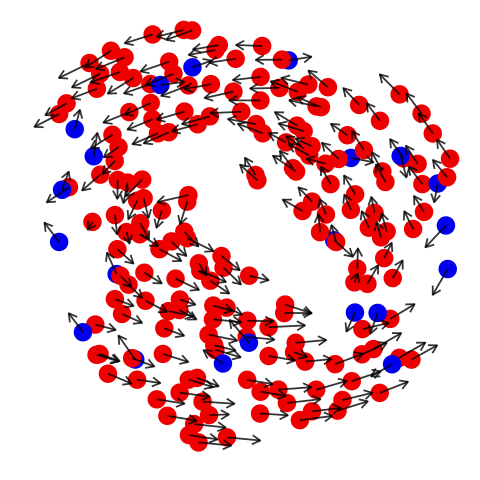

In [21]:
options(repr.plot.width=4, repr.plot.height=4)
ggplot_quiver(xdata-x_CM, ydata-y_CM, xv-xv_CM, yv-yv_CM, sc=0.05, is_clock_wise)

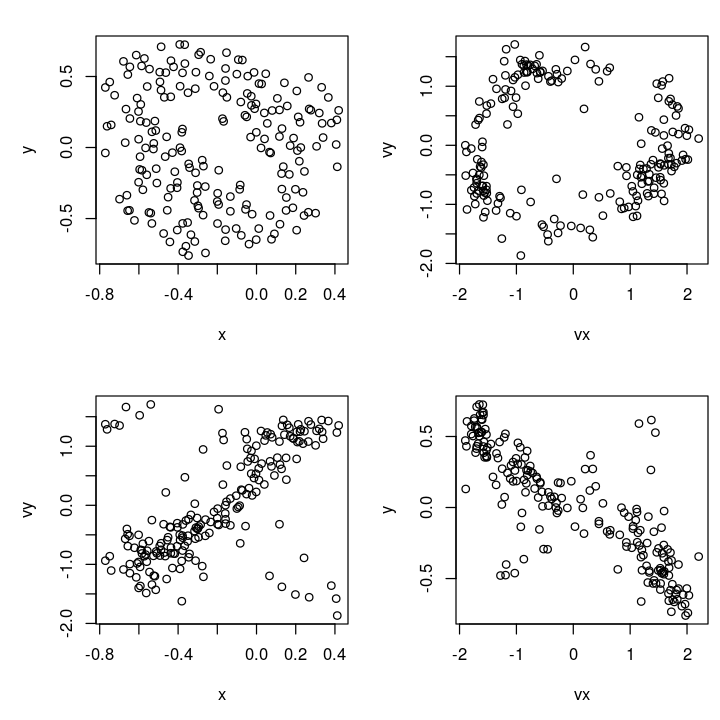

In [22]:
par(mfrow = c(2, 2), mai = c(0.8, 0.8, 0.3, 0.1))
options(repr.plot.width=6, repr.plot.height=6)

plot(xdata, ydata, xlab="x", ylab="y")
plot(xv, yv, xlab="vx", ylab="vy")
plot(xdata, yv, xlab="x", ylab="vy")
plot(xv, ydata, xlab="vx", ylab="y")

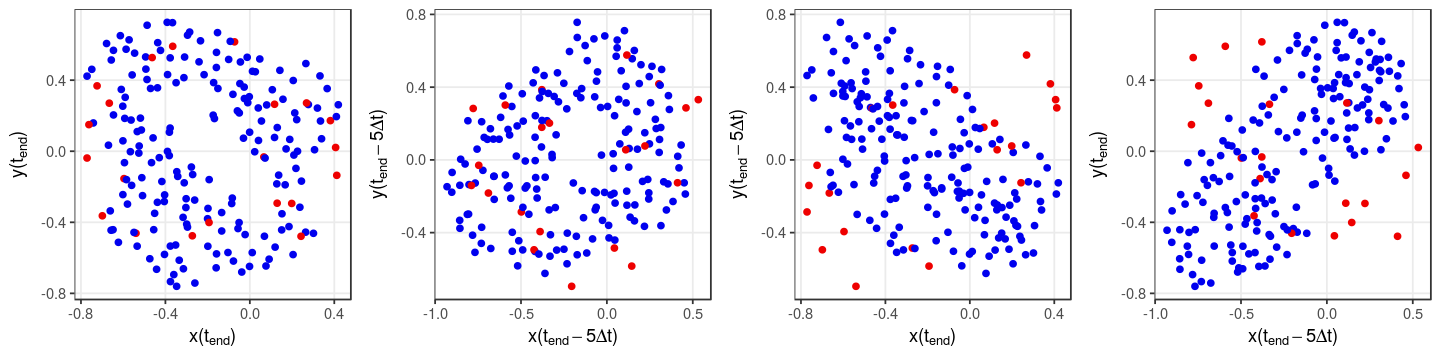

In [23]:
p1 = ggplot_sim(xdata, ydata, 
                x_label="$x(t_{end})$", y_label="$y(t_{end})$", is_clock_wise)
p2 = ggplot_sim(xdata_old, ydata_old, 
                x_label="$x(t_{end} - 5 \\Delta t)$", y_label="$y(t_{end} - 5 \\Delta t)$", is_clock_wise)
p3 = ggplot_sim(xdata, ydata_old, 
                x_label="$x(t_{end})$", y_label="$y(t_{end} - 5 \\Delta t)$", is_clock_wise)
p4 = ggplot_sim(xdata_old, ydata, 
                x_label="$x(t_{end} - 5 \\Delta t)$", y_label="$y(t_{end})$", is_clock_wise)

options(repr.plot.width = 12, repr.plot.height = 3)
grid.newpage()
grid.draw(cbind(ggplotGrob(p1), ggplotGrob(p2), ggplotGrob(p3), ggplotGrob(p4), size = "last"))